# Modelling Pharmacokinetics Pythonically
## Team Pandas

*Chong Zhen Yu, Lewin Turqueza, Nicholas Ng, Yong Han Ming* 

## 1. Introduction to Pharmacokinetics

Pharmacokinetics defines the interactions that a drug has to make with the body before it gets to the target. This is not to be confused with pharmacodynamics, which is the study of how the drug binds to the target. 

It is imperative to understand the pharmacokinetic profile of drugs in order for clinicians to be able to prescribe or administer the right dosage. Pharmacokinetics can be categorised into four processes in the following order: **Absorption, Distribution, Metabolism and Elimination** (ADME).

The following modules and plot styles will be used in this notebook.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy import stats
from scipy.integrate import simps
plt.style.use('seaborn')

### 1.1 Why is Pharmacokinetics important?

Imagine you have taken a vaccine against COVID-19. The side effects of the vaccinations include headache and fever, and your doctor recommends you to take paracetamol to counter the side effects.

Paracetamol is a pain reliever. It can be obtained over-the-counter (OTC). This means that there is no prescription needed to obtain the drug. However, as you take one tablet, you realise that your headache is not going away. Do you take one more pill or not? What would be the optimal dosage for you? This is where pharmacokinetics comes in.

Every drug is a potential poison. If too much is taken, even the best drugs will have detrimental effects on the human body. Paracetamol overdose is a growing problem and is a leading cause of acute liver failure today.

<img src="people.png" width="300"/>
<center><em>Approximately 51% of Acute Liver Failure (ALF) cases in 2003 were due to Paracetamol overdosage. Source: <a href="https://pubmed.ncbi.nlm.nih.gov/16317692/">Larson et al., 2005</a></em></center>

Like many drugs, paracetamol must first be dissolved in the bloodstream (an aqueous solution) in order to reach its target. When ingested, the concentration of a drug is increased. However, there is a maximum concentration of the drug your body can handle before toxic effects start to come in. This is known as the **maximum effective concentration**. Likewise, there also needs to be a minimum concentration of drug in your body in order for the drug to exhibit its beneficial effects, the **minimum effective concentration**. The concentration range between the maximum and minimum effective concentration is known as the **therapeutic range**.

There are multiple routes a drug can be administered. In this notebook, we will focus on the intravenous (IV) and oral forms. In the figure below, we will use the absorption profile of an oral dose to illustrate the therapeutic range.

In [4]:
# Please note that this curve is for visualisation purposes only, the values have no real meaning. 
# upper = maximum effective concentration, lower = minimum effective concentration 
 
def pharmacokinetics(upper = 1, lower = .25): 
    '''Plots a graph to visualise the concentration of an orally administered drug over time. The values in the graph are arbitary.
    The graph returns three coloured regions:
    Red: Toxic concentrations
    Green: Beneficial (optimal) concentrations
    Black: No effect is observed in these concentration range
    
    Arguments:
    upper: The minimum toxic concentration where there is a detrimental effect on normal physiological functions.
    lower: The minimum concentration of the drug that results in an observable beneficial physiological effect.'''
    
    if upper > lower:
        plt.figure(figsize=(10,10)) 

        # Determining time range
        time = np.arange(0, 5, 0.001) 

        # Creates a simple function to illustrate the pharmacokinetics curve  
        function_pharmacokinetics = lambda x: 5 * x * np.exp(-1.5 * x) 
        concentration = function_pharmacokinetics(time) 

        # Masks the points that are not required. i.e. to plot yupper, everything below the upper limit is hidden 
        y_upper = np.ma.masked_where(concentration < upper, concentration) 
        y_lower = np.ma.masked_where(concentration > lower, concentration) 
        y_middle = np.ma.masked_where((concentration < lower) | (concentration > upper), concentration) 

        # Plotting the 3 different bounds that are defined 
        plt.plot(time, y_middle, color = 'limegreen') 
        plt.plot(time, y_upper, color = 'red') 
        plt.plot(time, y_lower, color = 'black') 

        # Plotting horizontal lines to indicate limits 
        plt.hlines(upper, 0, 5, label = 'Maximum Effective Concentration', color = 'darkred', linestyle = '--') 
        plt.hlines(lower, 0, 5, label = 'Minimum Effective Concentration', color = 'g', linestyle = '--') 

        # Customisation
        plt.xlabel("Time", fontsize = 15)
        plt.ylabel("Concentration", fontsize = 15) 

        plt.ylim(0) 
        plt.xlim(0, 5) 

        plt.title("Plasma drug concentration over time (Oral Absorption)", fontsize = 15) 
        plt.legend(loc = 'center right', fontsize = 15) 
        
        plt.show()
        
    # Print error message if the bounds are set wrongly    
    else:
        print("Minimum Therapeutic Concentration(lower) needs to be lower than Minimum Toxic Concentration(upper)!")

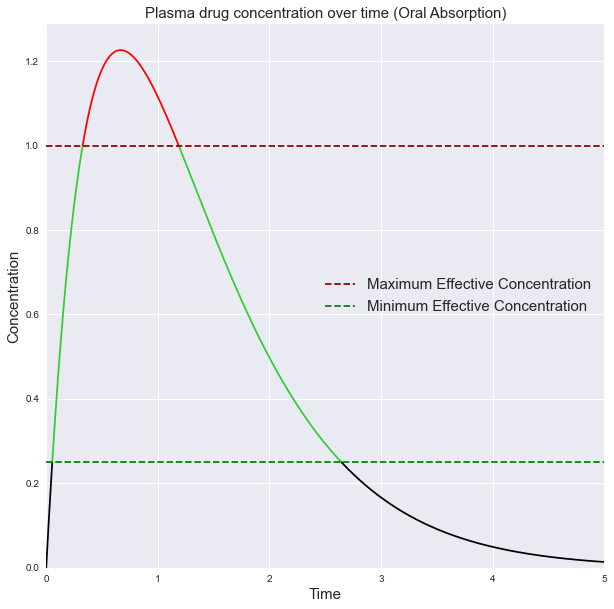

In [5]:
pharmacokinetics()

From the figure above, we learn that there can be a scenario the a dosage can cause the concentration of the drug to exceed the tolerable physiological threshold. This results in adverse unwanted effects on the body. Hence, knowing the optimal dose of the drug is necessary.

Ideally, one would like to regulate the dosage such that the drug concentration in the blood does not exceed the threshold, as seen in the curve below.

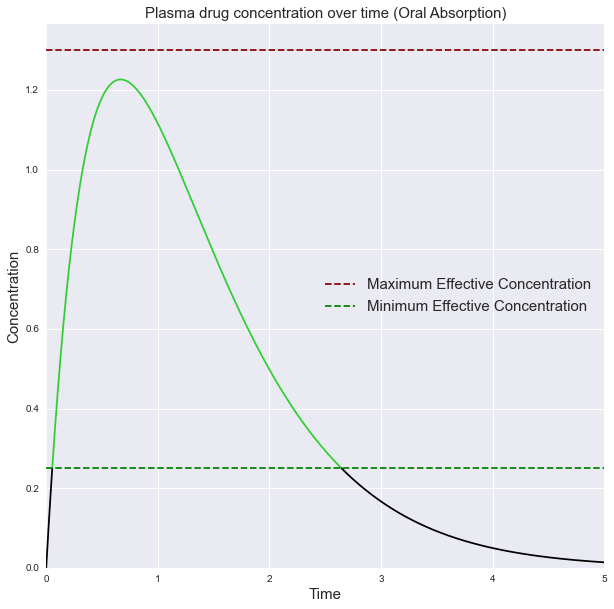

In [6]:
# Please note that this curve is for visualisation purposes only, the values are arbitary.
pharmacokinetics(1.3,.25)

### 1.2 Notebook Overview

This notebook will cover the basic concepts of pharmacokinetics to exemplify the important of correct drug dosing and explore how your body deals with the drug once it is administered.

We will be covering the following:
- **Chapter 2**: Absorption and Distribution - How does the drug enter the body and reach its target?
- **Chapter 3**: Metabolism - What are the chemical changes that occur to the drug?
- **Chapter 4**: Elimination - Why and how does the concentration of the drug in the body fall after over a period of time? How is the drug excreted?
- **Chapter 5**: Time to make your skills to good use! We will make use of the one-compartmental model to predict a dosage for diazepam. 
- **Chapter 6**: Addressing the limitations of the one-compartmental model, and a brief introduction of the two-compartmental model.
- **Chapter 7**: Final conclusion

### 1.3 Pharmacokinetic profiles of common drugs

In this notebook, we will be using and analysing a dataset comprising the pharmacokinetic profiles of ~1300 drugs in the market.

The souce of the dataset can be found here : [Lombardo et al., 2018](https://doi.org/10.1124/dmd.118.082966) 

In [7]:
# Read data from website
pk_data = pd.read_excel('https://dmd.aspetjournals.org/highwire/filestream/72048/field_highwire_adjunct_files/0/Supplemental_82966_revised_corrected.xlsx', skiprows = 8)

# Cleaning up data
pk_data.drop(columns= ['CAS #','fraction unbound \nin plasma (fu)','SMILES',
                       'Reference', 'Notes', 'Year of first disclosure',
                       'MoKa.LogD7.4', 'Comments ', 'RotBondCount'], inplace=True)

# Create a replacement dictionary to clean up the pk_data dataframe headers
my_to_replace = {
    'human VDss (L/kg)': 'Vol. Distribution (L/kg)',
    'human CL (mL/min/kg)': 'Clearance (mL/min/kg)',
    'MoKa.LogP' : 'LogP',
    'terminal  t1/2 (h)' : 'Half-life (h)',
    'MRT (h)' : 'Mean Residence Time (h)',
    'moka_ionState7.4' : 'Ionic State',
    'TPSA_NO':'Total Polar Surface Area',
    'MW': 'Molecular Weight'
}
pk_data.rename(my_to_replace, axis = 1, inplace = True)

To visualise this data, let us view the pharmacokinetic properties of acetaminophen (paracetamol) as well as some commonly prescribed antibiotics.

In [6]:
drugs = pk_data.loc[pk_data['Name'].isin(['Acetaminophen','Azithromycin', 'Cephalexin','Amoxicillin', 'Ciprofloxacin'])]
display(drugs)

,Name,Vol. Distribution (L/kg),Clearance (mL/min/kg),Mean Residence Time (h),Half-life (h),Molecular Weight,HBA,HBD,Total Polar Surface Area,Ionic State,LogP
20,Acetaminophen,1.00,5.0,3.30,2.50,151.16,3,2,49.3,neutral,0.76
71,Amoxicillin,0.25,3.3,1.30,1.10,365.40,8,4,133.0,zwitterionic,0.42
119,Azithromycin,33.00,10.0,57.00,69.00,748.98,14,5,180.1,cationic,2.20
250,Cephalexin,0.21,3.9,0.89,0.57,347.39,7,3,112.7,zwitterionic,-0.27
288,Ciprofloxacin,2.10,8.3,4.20,3.80,331.34,6,2,72.9,zwitterionic,1.80


The following are some summary statistics for this dataframe of 1352 drugs.

In [7]:
pk_data.describe().round(2).iloc[1:]

,Vol. Distribution (L/kg),Clearance (mL/min/kg),Mean Residence Time (h),Half-life (h),Molecular Weight,HBA,HBD,Total Polar Surface Area,LogP
mean,3.83,12.21,17.24,17.06,474.05,8.99,3.47,130.47,1.65
std,20.79,48.73,74.32,71.81,485.30,12.65,6.83,203.58,2.92
min,0.03,0.00,0.01,0.02,42.04,0.00,0.00,0.00,-9.00
25%,0.30,1.70,1.77,1.75,285.75,4.00,1.00,58.40,0.19
50%,0.91,4.58,3.92,4.40,371.10,6.00,2.00,88.90,2.00
75%,2.60,11.00,11.00,11.90,485.10,9.00,3.00,132.77,3.50
max,700.00,1070.00,1400.00,1344.00,7158.00,189.00,101.00,2895.90,9.00


## 2. Absorption and Distribution

### 2.1 Absorption - How it gets in

Absorption deals with how much of the administered dose of a drug is able to reach the circulatory system, and is one of the most important principles of pharmacokinetics. Mechanisms of drug absorption include passive diffusion, carrier-mediated membrane transport such as active and facilitated diffusion, and other nonspecific drug transporters, such as P-glycoprotein.

#### Hydrophobicity and LogP Values of Drugs

One of the most important determinants of a drug's absorption rate is its **LogP value**, which can be obtained by taking the logarithm of a drug's partition coefficient (P). P is defined as a particular ratio of the concentrations of a solute between two solvents, one of which is water and the other a non-polar solvent (usually n-octanol). It is hence a measure of a **hydrophobicity or lipophilicity**: the more positive its value, the more hydrophobic or lipophilic (ability to dissolve in fats or lipids) it will be. 

The equation is as follows:


$$ logP = log \frac{[solute]_{n-octanol}}{[solute]_{water}}      $$


Using the pharmacokinetic profile datafile mentioned above, let us see the distribution of logP values of the drugs using the following histogram.

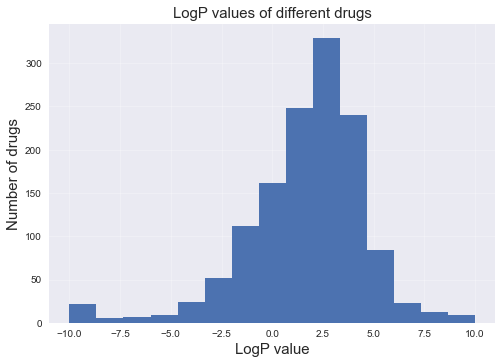

In [9]:
# Plotting histogram of logP values
ax1 = pk_data.hist('LogP', bins = 15, range = (-10,10))

# Plot customisations and labelling
plt.title('LogP values of different drugs', fontsize = 15)
plt.ylabel('Number of drugs', fontsize = 15)
plt.xlabel('LogP value', fontsize = 15)
plt.grid(alpha = 0.25)

plt.show()

If you notice, most drugs have a positive logP value, with the majority possessing a logP value of around 2.3. This shows that most drugs are usually lipophilic than hydrophilic. This is because drugs have to pass through a simliarly lipophilic cell surface membrane to enter and pass the intestinal epithelial (surface) cells to enter the bloodstream.

#### Bioavailability

The extent of drug absorption into systemic circulation, also known as **bioavailability** (F), varies among different routes of administration, such as oral, subcutaneous (SC), transdermal, intravenous (IV), and intramuscular (IM).  F is a percentage less than or equal to 100, with IV administration having an F value of **100%** (since the drug is injected straight into the bloodstream). Other routes of administration will have a smaller F value since drugs administered through other routes may be lost before absorption.


Most drugs that are administered orally are not fully absorbed into the circulatory system, and this extent of absorption depends on a wide range of factors, including the very nature of the drug itself (solubility, $pK_a$[acid dissociation constant]), as well as the physiological environment (pH, gastrointestinal motility that leads to the drug being excreted before absorption).  


### Pharmacokinetic Equations

To explain biolavailability, we shall be using these pharmacokinetic equations to model the following:


**Oral Administration**

$$ C(t) = \frac{ F \cdot D \cdot k_a } {Vd \cdot (k_a - k_e) } \cdot (e^{-k_e \cdot t} -  e^{-k_a \cdot t})   $$  

**I.V. Adminstration**

$$ C(t) = C_0 \cdot e^{-k_e \cdot t} $$


where

$ C(t)$ = Concentration of drug at particular time 

$ F $ = Bioavailability

$ D $ = Dose 

$ k_a $ = Absorption rate constant 

$ k_e $ Elimination rate constant

$ Vd $ = Volume of distribution 

$ C_0$ = Initial concentration (which can be calculated by $ \frac{D}{Vd} $ )

Using these equations and arbitrary constants, we can plot the following curves to see how the drug plasma concentration over time differs between IV administration and oral administration.

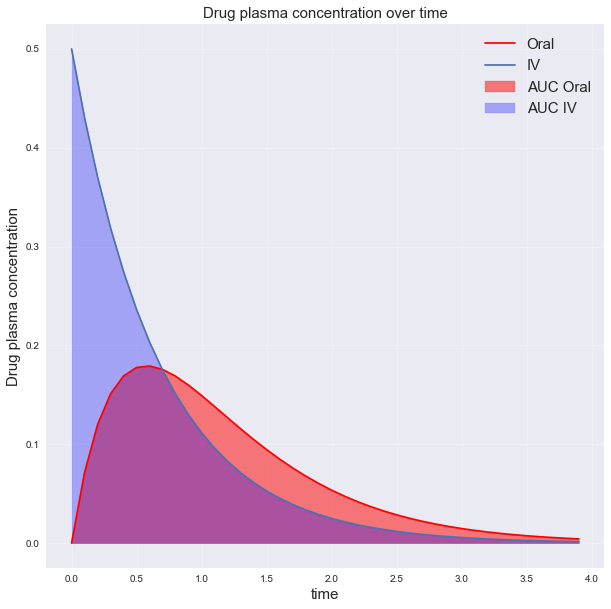

In [10]:
# Create time range
t = np.arange(0,4,0.1)

# Arbitrary pharmacokinetic constants
F = 0.85
D = 0.5
Ka = 2
Ke = 1.5
Vd = 1
C_0 = D/Vd

# Modelling the drug plasma concentrations using the pharmacokinetic equations for both oral and iv dose
oral_dose = ((F * D * Ka) / (Vd * (Ka - Ke))) * (np.exp(- Ke * t) - np.exp(- Ka * t))
iv_dose = C_0 * np.exp(-Ke *t)

# Plotting the graph
plt.figure(figsize = (10,10))
plt.plot(t,oral_dose, color = 'red')
plt.plot(t,iv_dose)

# Plot customisations
plt.title('Drug plasma concentration over time', fontsize = 15)
plt.ylabel('Drug plasma concentration', fontsize = 15)
plt.xlabel('time', fontsize = 15)
plt.grid(alpha = 0.2)

# Visualising the Area Under Curve (AUC)
plt.fill_between(t, oral_dose, 0, color = 'r', alpha = 0.5)
plt.fill_between(t, iv_dose, 0, color = 'b', alpha = 0.3)

# Adding the legend
plt.legend(['Oral','IV', 'AUC Oral', 'AUC IV'], fontsize  = 15)

plt.show()

The absolute bioavailability of a drug can be measured by comparing the concentration of plasma drug (administered orally) concentration over time with that of intravenous administration. Specifically, we can calculate the ratios of the **area under curve (AUC)** values, which evaluates the bioavailibility, F, of the oral route of administraion.

$$ F = 100 \cdot \frac{AUC_{oral}}{AUC_{iv}}      $$

In our model above, we arbitarily assigned the F value to be 85%. We can confirm this value by finding the ratios of the AUC using integration.

In [11]:
# Proving that the bioavailability is 0.85

# Returns the concentration of the oral drug at each time point
def oral_dose(t):
    ''' Returns the concentration of the oral drug in the plasma in the circulatory system when time = t'''
    return ((F * D * Ka) / (Vd * (Ka - Ke))) * (np.exp(- Ke * t) - np.exp(- Ka * t))

# Returns the concentration of the IV drug at each time point
def iv_dose(t):
    ''' Returns the concentration of the iv drug in the plasma in the circulatory system when time = t '''
    return C_0 * np.exp(-Ke *t)


# Using the simps package from scipy will allow us to obtain AUC through integration

# Determine the AUC for oral drug
AUC_oral = simps(oral_dose(t))
print(f'Area under curve (oral) is {AUC_oral}.\n')

# Determine the AUC for iv drug
AUC_IV = simps(iv_dose(t))
print(f'Area under curve (iv) is {AUC_IV}.\n')

# Calculate the bioavailibility
bioavail = 100 * (AUC_oral / AUC_IV)

print(f'Bioavailability is {bioavail.round(2)}%.')

Area under curve (oral) is 2.8030551710046723.

Area under curve (iv) is 3.3241789194678435.

Bioavailability is 84.32%.


### 2.2 Distribution

After absorption into systemic circulation, a drug will then be distributed via the blood into the site of action, where it will exert its effect. 

The drugs may be found in:

1. Blood Plasma
2. Platelets
3. Attached to plasma proteins

Depending on its physiochemical characteristics, it may not distribute evenly across all tissues. 

#### Volume of Distribution

The Apparent volume of distibution, or Vd, is an attribute of a drug that approximates the affinity of a drug molecule to bind to different tissues. It is one of the key parameters that affects how long a drug stays in the body. 


$$ V_d =  \frac{Amount}{Concentration \space of \space drug \space in \space plasma}      $$


The higher the Vd, the greater the probability the the drug will be found in the extravascular tissues. Typically, drugs with smaller sizes, higher lipophilicity (higher LogP value) and higher percentage of tissue protein binding, will have a higher volume of distribution. This is because these drugs will be able to perfuse through the tissues more easily.  

To confirm this, we can use the data set we defined earlier to analyse how the Vd of drugs vary with molecular mass and LogP values. 

(For reference, we have highlighted paracetamol's properties accordingly in the plotted graphs.)

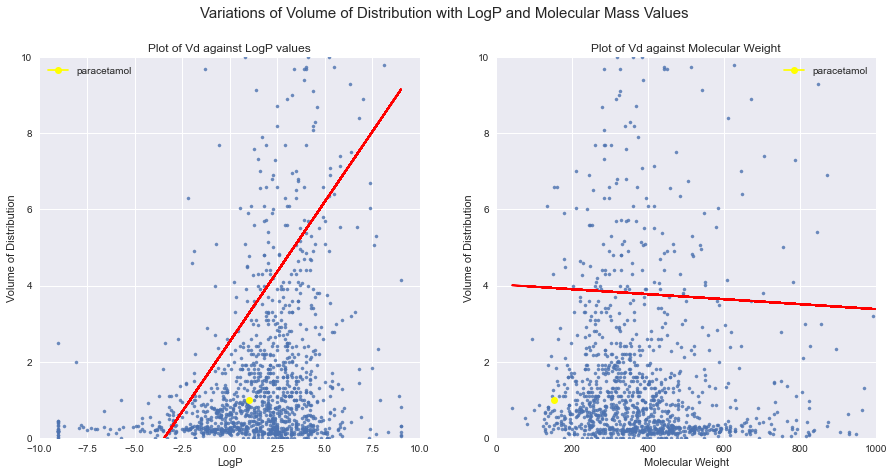

The r squared value of Vd against LogP is 0.01091, gradient of best fit line is 0.73611, y-intercept is 2.52359.
The r squared value of Vd against molecular weight is 0.00024, gradient of best fit line is -0.00066, y-intercept is 4.0354.


In [11]:
# Obtaining data for each pharmacokinetic parameter, and filling 'NaN' values with zeros
logp_values = pk_data['LogP'].fillna(0)
vd_values = pk_data['Vol. Distribution (L/kg)'].fillna(0)
mw_values = pk_data['Molecular Weight'].fillna(0)


# Obtaining paracetamol's parameters:
paracetamol_vd = np.array(pk_data.loc[pk_data["Name"].isin(["Acetaminophen"])]["Vol. Distribution (L/kg)"].iloc[0])
paracetamol_logp = np.array(pk_data.loc[pk_data["Name"].isin(["Acetaminophen"])]["LogP"].iloc[0])
paracetamol_mw  = np.array(pk_data.loc[pk_data["Name"].isin(["Acetaminophen"])]["Molecular Weight"].iloc[0])

# Using scipy.stats to find the linear regression statistics
vd_logp = stats.linregress(logp_values, vd_values)
vd_mw = stats.linregress(mw_values, vd_values)

# Plotting the subplots 
fig, ax = plt.subplots(nrows = 1, ncols =2 , figsize = (15,7))
fig.suptitle('Variations of Volume of Distribution with LogP and Molecular Mass Values', fontsize = 15)

# Plotting Vd against LogP
ax[0].plot(paracetamol_vd, paracetamol_vd, color = 'yellow', marker = 'o', label = 'paracetamol')  # Paracetamol data point
ax[0].legend()

ax[0].scatter(logp_values , vd_values, alpha = 0.8, s = 10) # Scatter plot
ax[0].plot(logp_values, vd_logp.intercept + vd_logp.slope*logp_values, color = 'red') # Plot of line of best fit

ax[0].set_title('Plot of Vd against LogP values')

ax[0].set_xlim([-10,10])
ax[0].set_ylim([0,10])

ax[0].set_ylabel('Volume of Distribution')
ax[0].set_xlabel('LogP')


# Plotting Vd against Molecular Weight
ax[1].plot(paracetamol_mw, paracetamol_vd, color = 'yellow', marker = 'o', label = 'paracetamol') # Paracetamol data point
ax[1].legend()

ax[1].scatter(mw_values, vd_values, alpha = 0.8, s = 10) # Scatter plot
ax[1].plot(mw_values, vd_mw.intercept + vd_mw.slope*mw_values,color = 'red') # Plot of line of best fit

ax[1].set_title('Plot of Vd against Molecular Weight')
ax[1].set_xlim([0,1000])
ax[1].set_ylim([0,10])

ax[1].set_ylabel('Volume of Distribution')
ax[1].set_xlabel('Molecular Weight')

plt.show()

## Print r squared values
print(f"The r squared value of Vd against LogP is {(vd_logp.rvalue**2).round(5)}, gradient of best fit line is {vd_logp.slope.round(5)}, y-intercept is {vd_logp.intercept.round(5)}.")
print(f"The r squared value of Vd against molecular weight is {(vd_mw.rvalue**2).round(5)}, gradient of best fit line is {vd_mw.slope.round(5)}, y-intercept is {vd_mw.intercept.round(5)}.")

From the trend lines, we see a positive correlation between LogP and Vd values, suggesting that increasing liphophillicity results in greater Vd.

Similarly, we see a  negative correlation between Molecular Weight and Vd values, suggesting that bigger molecules will have a smaller Vd.

However, from the r squared values obtained from the scipy stats module, we see that the correlation may not be very significant. A host of other factors may hence contribute to the large variability of Vd values.

## 3. Metabolism

### 3.1 The importance of metabolism

Being foreign chemical compounds, drugs can undergo chemical reactions in the body. Some drugs need to be chemically modified to be activated in the body. However, some drugs that can undergo uncontrolled chemical reactions might cause the drug to have unintended effects.

Metabolism has two main functions: **drug activation** and **increasing the water solubility** of the drug for excretion. These are performed by the cytochrome P450 enzymes in the liver. These enzymes are unique as they act on a range of substrates (bearing functional groups), compared to conventional enzymes that are specific for a single substrate.

### 3.2 Drug activation
Drug activation involves the enzymatic conversion of the inactive drug (also known as the **prodrug**) into the active drug form. While paracetamol exists as its active form, one common example of drug activation is the in-vivo conversion of codeine into morphine, a common pain relieving drug (analgesic).
<img src="codeine.jpg" width="500"/>

<center><em>Codeine is metabolised to form Morphine. Morphine is then further metabolised to M3G and M6G. Source: <a href="https://www.researchgate.net/publication/308907050_Degradation_of_Opioids_and_Opiates_During_Acid_Hydrolysis_Leads_to_Reduced_Recovery_Compared_to_Enzymatic_Hydrolysis">Sitasuwan et al., 2016</a></em></center>


Codeine is demethylated (removal of a methyl group) to form morphine. This is catalysed by the CTP2D6 enzyme. Morphine can be further conjugated with glucuronic acid to form morphine-6-glucuronide (M6G) and morphine-3-glucuronide (M3G). Potency studies have elucidated the binding affinities of these compounds. The greater the binding of the drug to the **mu-opioid receptor**, the lower the **dissociation constant** ($K_i$) and thus the greater the potency of the drug.

Data adapted from [Chen et al., (1991)](https://doi.org/10.1016/0024-3205(91)90150-A)

In [12]:
# Opioid data for Ki values
opioid_data = {"Compound":["Codeine", "Morphine", "M3G", "M6P"],
               "$K_i$ values":[248.3, 1.2, 37.1, 0.6]}  
affinities = pd.DataFrame(opioid_data) # Creates a Pandas dataframe with opioid Ki data
display(affinities)

,Compound,$K_i$ values
0,Codeine,248.3
1,Morphine,1.2
2,M3G,37.1
3,M6P,0.6


To demonstate the relative affinity of each drug, we will take the reciprocal of each $K_i$ value.


In [13]:
# Creates a new column with relative affinities
affinities["Relative Affinity"] = 1 / affinities["$K_i$ values"]

We will now graphically compare these values in a bar plot.

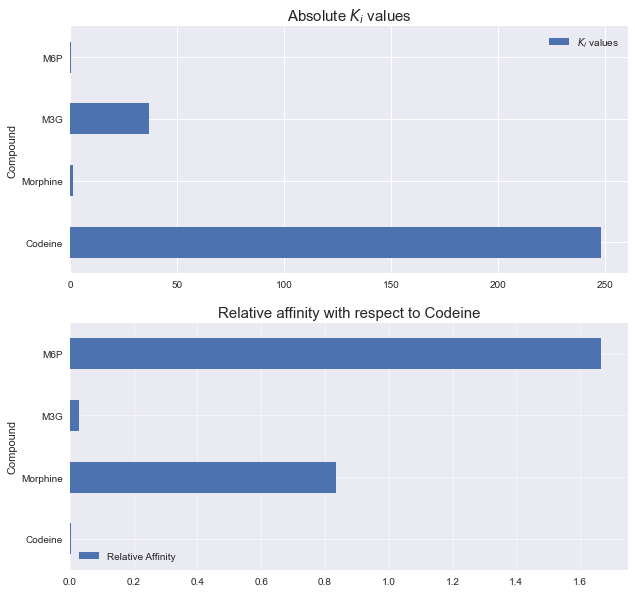

In [14]:
# Plotting two barplots with subplots
fig, ax = plt.subplots(nrows = 2, ncols = 1, figsize = (10,10))
ax_absolute, ax_relative = ax

affinities.loc[:,["Compound", "$K_i$ values"]].plot(kind = "barh", x = "Compound" ,ax= ax_absolute)
affinities.loc[:,["Compound", "Relative Affinity"]].plot(kind = "barh", x = "Compound", ax = ax_relative)

ax_absolute.set_title(r"Absolute $K_i$ values", fontsize = 15)
ax_relative.set_title("Relative affinity with respect to Codeine", fontsize = 15)

plt.grid(alpha = 0.5)

plt.show()

This graphical representation demonstrates the **significantly higher potency** of morphine and M6P over codeine. With drug metabolism, codeine (which is metabolised to morphine) will acheive an effect that is approximately 207 times more than the initial codeine state. The metabolites M3G and M6G are also about 7 and 414 times more potent than codeine respectively. This is important to allow codeine to achieve its analgesic effect without an overdose, which might cause other unintended effects in the body.

### 3.3 Metabolism for excretion
On the other hand, the cytochrome enzymes also function to metabolise the drug such that it is more easily excreted by the body. Drugs are foreign chemicals in the body, and the liver is designed as a **detoxifying organ** to reduce the chances of these chemicals infliciting damage on body cells.

One way to remove the drug from the bodily system is to **increase its water solubility**. This can be done through oxidising functional groups to increase their polarity, or adding conjugate groups to the molecule to increase its solubility. An increased solubility allows for the new compound to compartmentalise in the **kidneys**, thus increasing their chances of excretion from the body.
<img src="metabolism.png" width="500"/>
<center><em>The metabolites of Paracetamol.Source: <a href="https://www.researchgate.net/publication/270291012_Paracetamol_and_analgesic_nephropathy_Are_you_kidneying_me">Waddington et al., 2015</a> </em></center>

The following are some parameters of paracetamol and its major metabolites.

In [15]:
# Metabolite data
metabolite_data = {"Compound":["Paracetamol", "Paracetamol Glucuronide", "Paracetamol Sulfate", "NAPQI"],
                  "Hydrogen Bond Donors":[2,5,2,0],
                  "Hydrogen Bond Acceptors":[2,8,4,3],
                  "Formation(%)":[0,60,30,10],
                  "Solubility in water (g/L)":[4.15,27.7,1.54,0.99]} 
  
# Create a Pandas dataframe with metabolite data
metabolites = pd.DataFrame(metabolite_data) 
metabolites["Relative number of hydrogen bonds in water"] = metabolites["Hydrogen Bond Donors"] + metabolites["Hydrogen Bond Acceptors"] #Creates a new column with relative number of hydrogen bonds in water
display(metabolites)

,Compound,Hydrogen Bond Donors,Hydrogen Bond Acceptors,Formation(%),Solubility in water (g/L),Relative number of hydrogen bonds in water
0,Paracetamol,2,2,0,4.15,4
1,Paracetamol Glucuronide,5,8,60,27.70,13
2,Paracetamol Sulfate,2,4,30,1.54,6
3,NAPQI,0,3,10,0.99,3


Sources for the respective data can be found from the Human Metabolome Database:

- [Paracetamol](https://hmdb.ca/metabolites/HMDB0001859)

- [Paracetamol glucuronide](https://hmdb.ca/metabolites/HMDB0010316) 

- [Paracetamol sulfate](https://hmdb.ca/metabolites/HMDB0059911) 

- [NAPQI](https://hmdb.ca/metabolites/HMDB0060946)

The metabolism or conjugation of paracetamol into its metabolites leads to the formation of some water soluble compounds. The greater the solubility of the compound, the higher the potential to be compartmentalised in the kidneys for greater excretion out of the body. 

A measure of the polarity of a compound can be estimated by summing the total number of **hydrogen bond donors and hydrogen bond acceptors**. A higher sum of the donors and acceptors implies that polar atoms and groups such as nitrogen, oxygen and alcohols are added to the compound. These groups can subsequently form favourable hydrogen bonds with water molecules, which increases the solubility of the compound. 

The data will be visualised in the following scatter plot and line of best fit.

r squared value = 0.91, gradient of best fit line = 2.71213, y-intercept = -9.03385


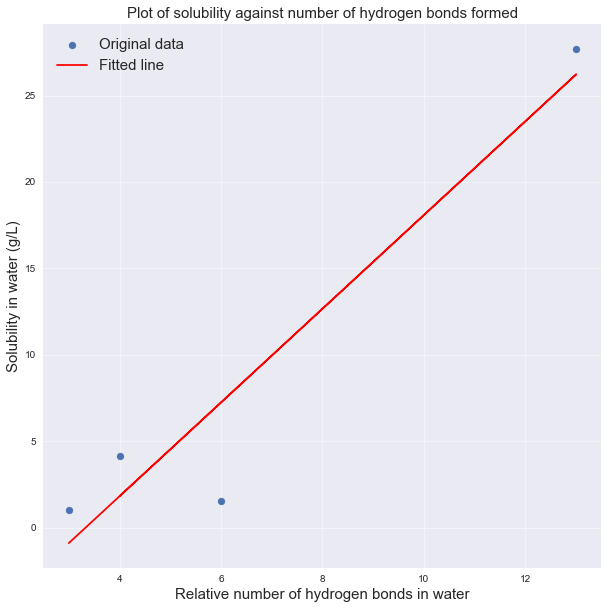

In [16]:
# Slice the dataframe into the relavent data for this plot
plot1 = metabolites.loc[:,["Compound","Relative number of hydrogen bonds in water",
                           "Solubility in water (g/L)"]] 

x = np.array(plot1.loc[:, "Relative number of hydrogen bonds in water"])
y = np.array(plot1.loc[:, "Solubility in water (g/L)"])

# Using scipy linregression to generate regression statistics
regress_stats = stats.linregress(x,y)

# Print r squared value
print(f"r squared value = {(regress_stats.rvalue**2).round(2)}, gradient of best fit line = {regress_stats.slope.round(5)}, y-intercept = {regress_stats.intercept.round(5)}")

# Plotting graphs
plt.figure(figsize=(10,10))
plt.scatter(x, y, label = "Original data") # Plotting the scatter graph
plt.plot(x, regress_stats.intercept + regress_stats.slope*x, color = 'red',
         label = 'Fitted line') # Plotting the best fit line

plt.xlabel("Relative number of hydrogen bonds in water", fontsize = 15)
plt.ylabel("Solubility in water (g/L)", fontsize = 15)
plt.title("Plot of solubility against number of hydrogen bonds formed", fontsize = 15)

plt.legend(fontsize = 15)
plt.grid(alpha = 0.5)

plt.show()

Indeed, by using a best-fit line on a scatter plot, the line reinforces that the increased hydrogen bonding potential is **positively associated** with its solubility in water.

As paracetamol glucuronate has the highest solubility in water, it is expected that most paracetamol molecules would be converted into this species. The trend of the percentage formation and the compound’s solubility in water can be seen from the bar plots below. As expected, if a compound is able to form more hydrogen bonds in water, this allows it to form more favourable interactions in aqueous solution over interactions within drug molecules, thus increasing the solubility of the drug.

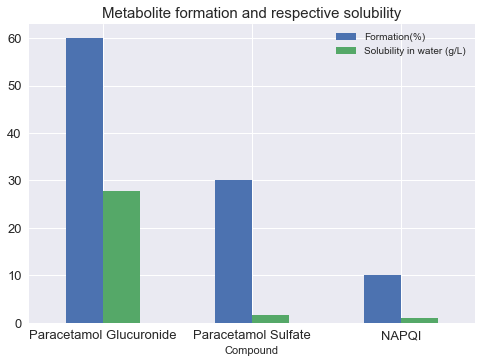

In [17]:
# Slice the dataframe into the relavent data for this plot
plot2 = metabolites.loc[:,["Compound","Formation(%)","Solubility in water (g/L)"]] 

# Drops the first row, "Paracetamol" as we are now focusing on its metabolites
plot2 = plot2.iloc[1: , :] 

# Plots a bar chart for the data associated with "Compound"
plot2.plot.bar(x = "Compound", rot = 0, fontsize = 13) 
plt.title("Metabolite formation and respective solubility", fontsize = 15)

plt.show()

Hence, the trend suggests that when the **solublilty of the metabolite decreases, it is less likely to be formed**. This aligns with the aim of metabolism to convert foreign chemicals into water-soluble species for greater excretion from the body.

<img src="NAPQI.png" width="300"/>
<center><em>Structural formula of NAPQI. Source: <a href="https://en.wikipedia.org/wiki/N-acetyl-p-benzoquinone_imine#/media/File:N-Acetyl-p-benzochinonimin.svg">Wikimedia Commons</a></em></center>

N-acetyl-p-benzoquinone imine (**NAPQI**) is a **toxic** by-product of the metabolism of paracetamol. Normally, NAPQI is further metabolised to other species for excretion. However, in toxic does of paracetamol, the usual glucuronation pathway is saturated and NAPQI is formed in greater amounts. An accumulation of NAPQI is believed to bind to liver proteins, causing liver damage. This mechanism has been linked to the acute liver failure seen in paracetemol overdose. 

### 3.4 Discussion
As the body’s gatekeeper to foreign substances, the liver plays a key role in ensuring that drug levels are kept at an optimal to prevent an over concentration of a drug in the blood plasma. Metabolism studies remain crucial in every drug design to elucidate the transformation pathways of the new drug, in order to determine if it can be cleared quickly, or if it forms toxic products. At the same time, the liver must work with other organs to excrete these metabolised products. Thus, **excretory organs** such as the kidney and lungs play an equally essential role in pharmacokinetics.

# 4. Elimination

### 4.1 The Significance of Elimination

Elimination is the removal of the drug and metabolites from the system through the utilization of multiple organs such as the kidney, liver and lungs. Excretion is important as the **accumulation of toxic foreign substances** can adversely affect metabolism in humans.

The kidney is the primary site of excretion and water-soluble products are excreted via urine. Another method of excretion is biliary excretion. This is initiated in the liver, causing fat-soluble products to pass through the guts to be excreted as feces. The last main method of excretion is through the lungs.

Most drugs follow **first order elimination kinetics** and is assumed to be a one compartmental model (we will cover the one compartmental model in more detail in Chapter 6). With first order elimination, the amount of drugs eliminated in a fixed time interval is **directly proportional** to the amount of drug in the body. The amount of drug eliminated over a period of time increases as the amount of drug increases, and vice versa. This concept is unlike zero order elimination, where the amount of drug eliminated for each time interval is constant, regardless of the amount of drug in the body.

A straight line can depict the change in natural logarithm of drug plasma concentration over time. Using this relationship, we can utilize mathematical methods to predict drug concentrations.

$$ y = mX+c $$

where $m$ is the slope of the line and $b$ is the intercept of the y-axis. The slope of the line is calculated from the change in the y-axis divided by the change in the x-axis. We can apply these same mathematical principles to the natural logarithm of drug plasma concentration against time.

$$ ln(Concentration) = \frac{ln(C_1) - ln(C_0)}{t_1 - t_0} \cdot t + b $$
where

$C_0$: initial concentration

$t_0$: start time

$C_1$: concentration at time = $t_1$

$t_1$: time after interval

$b$: y-intercept

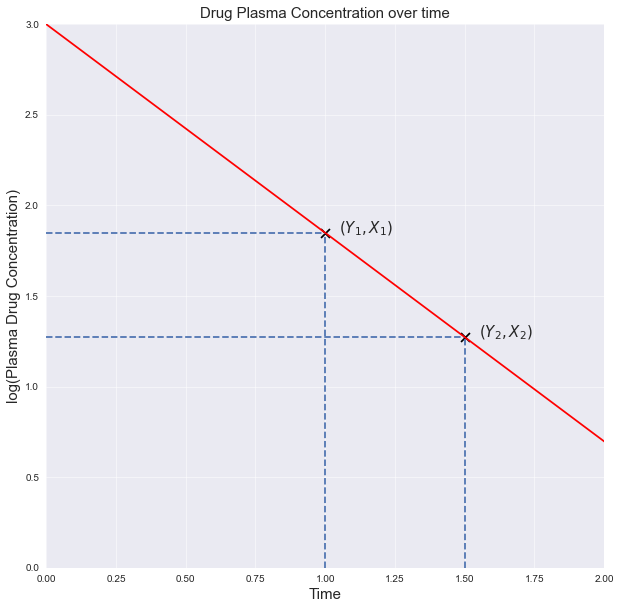

In [18]:
# Arbitary pharmacokinetic constants

C1 = 1
C0 = 10
t1 = 2
t0 = 0
b = 3

# Defining m, the gradient of the equation stated above
m = ((np.log(C1)-np.log(C0))/ t1 - t0)

# Plotting a point when t = 1
x1 = 1
y1 = m * x1 + b

# Plotting a point when t = 1.5
x2 = 1.5
y2 = m * x2 + b

# Modelling the drug plasma concentrations using the pharmacokinetic equations

# Set time range
t = np.arange(0,3,0.2)

# Plotting logarithm graph
Log_plasmaconc = (m* t) + b

# Plotting two points at t = 1 and t = 1.5
plt.figure(figsize = (10,10))
plt.scatter(x1, y1, marker ='x', s = 80, color ='k')
plt.scatter(x2, y2, marker ='x', s = 80, color ='k')

# Drawing guide lines for t = x1
plt.hlines(y = y1, xmin = 0, xmax = 1,
            linestyle='dashed')
plt.vlines(x = x1, ymin = 0, ymax = y1,
           linestyle='dashed')

# Drawing guide lines for t = x2
plt.hlines(y = y2, xmin = 0, xmax = 1.5,
            linestyle='dashed')
plt.vlines(x = x2, ymin = 0, ymax = y2,
            linestyle='dashed')
plt.plot(t, Log_plasmaconc, color = 'red')

# Adding labels to the points
plt.text(x1 + 0.05, y1, "$(Y_1,X_1)$", fontsize = 15)
plt.text(x2 + 0.05, y2, "$(Y_2,X_2)$", fontsize = 15)

# Customising limimts
plt.xlim(0,2)
plt.ylim(0,3)

plt.title('Drug Plasma Concentration over time', fontsize = 15)
plt.ylabel('log(Plasma Drug Concentration)', fontsize = 15)
plt.xlabel('Time', fontsize = 15)
plt.grid(alpha = 0.5)

plt.show()

The slope of the line indicates the rate that the drug is eliminated. A steeper slope indicates a faster rate of elimination. The slope of a straight line can be determined from any two points on the line. For first order processes, the rate of elimination is the same regardless of concentration and is termed as **elimination rate constant ($k_e$)**. Hence:

$ k_e = -m $

where $k_e$ is the elimination rate constant and $m$ is the gradient of the line.

### 4.2 Half-life

Another significant variable affecting the rate of drug elimination is half-life. Half-life is the time taken for the concentration of the drug in the plasma to decrease by half. A drug's half-life is linked to the duration of action and is indicative of when another dose should be adminstered. For first-order elimination, the half-life equation is the following:

$$ t_{1/2} = \frac{ln2}{k_e} $$

where $k_e$ is elimination rate constant and $t_{1/2}$ is the half-life of the drug.

Another method to determine half-life is to visually inspect the natural logarithm of plasma concentration against time plot and observe the time taken for the drug plasma concentration to decrease by half. This is demonstrated in the following graph.

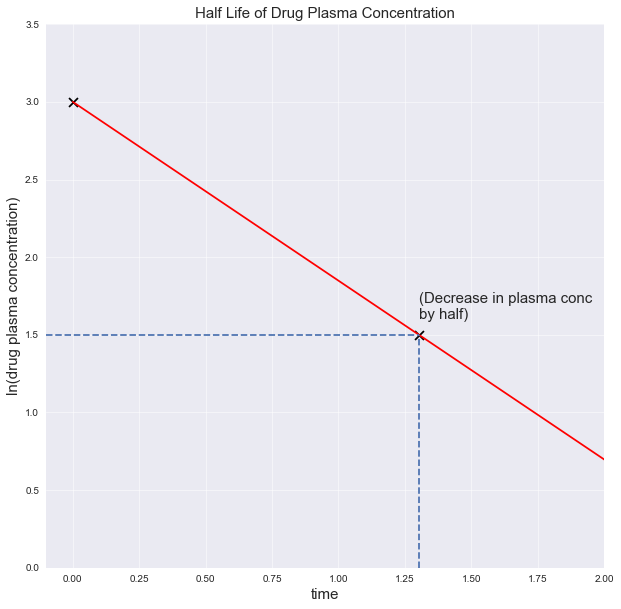

The half life of the drug is 1.30288 hours.


In [19]:
# Set time range
time = np.arange(0,3,0.2)

# Pharmacokinetic constants (arbitrary), for visualisation purposes only
# C = concentration of drug in plasma, t = time, b = y-intercept 
C1 = 1
C0 = 10
t0 = 0
t1 = 2
b = 3

# Defining m, the gradient of the equation
m = ((np.log(C1)-np.log(C0))/ t1 - t0)
ln_plasmaconc = (m * time) + b 

# Plotting the graph
plt.figure(figsize=(10, 10))
plt.plot(time, ln_plasmaconc, color = 'red')

# PLotting two points showing half concentration, b and (b/2)
plt.scatter(t0, b, marker = 'x', s = 80, color = 'k')

# Solving the equation for t when y = b/2, and plot t
plt.scatter(((b/2)-b)/m, b/2, marker = 'x', s = 80, color = 'k')

# Drawing guiding lines
plt.hlines(y = (b/2), xmin = -.1, xmax = ((b/2)-b)/m,
           ls = 'dashed')
plt.vlines(x = ((b/2)-b)/m, ymin = 0, ymax = (b/2),
           ls = 'dashed')

# Adding a text label
plt.text(((b/2)-b)/m, (b/2) + 0.1, "(Decrease in plasma conc \nby half)", fontsize = 15)

plt.title('Half Life of Drug Plasma Concentration', fontsize = 15)
plt.ylabel('ln(drug plasma concentration)', fontsize = 15)
plt.xlabel('time', fontsize = 15)

plt.xlim(-0.1, 2)
plt.ylim(0, 3.5)
plt.grid(alpha = 0.5)

plt.show()

# Display the numerical value of the half life
half_life = (1.5-3)*2/-np.log(10)
print(f"The half life of the drug is {half_life.round(5)} hours.")

### 4.3 Clearance

Clearance is a quantitative descriptor for the elimination of specific drugs. **It describes the volume of the blood that is cleared of the drug over a period of time**. As mentioned in Chapter 4, drugs are cleared through many different pathways. Total body cleareance of a drug is the sum of all the different clearance mechanisms.

$$ CL_t = CL_r + CL_m + CL_b + CL_o   $$

where

$CL_t$ = total body clearance

$CL_r$ = renal clearance

$CL_m$ = clearance by liver metabolism

$CL_b$ = biliary clearance

$CL_o$ = clearance by all other routes, i.e. respiratory

It is more useful than the elimination rate as clearance **does not fluctuate** with different drug concentrations in the system. It reflects the intrinsic ability of the body to clear the specific drug, and is usually constant over a wide range of concentrations.

$$ Clearance = \frac{Elimination Rate}{Concentration} $$

Alternatively, using the concepts we were taught previously, we can calculate clearance as:



$$ Clearance = \frac{ln2}{half-life} \cdot V_d $$

$$ \rightarrow k_e = \frac{Clearance}{V_d} $$

With this, we can model the effect of half-life and its effect on clearance. Using paracetamol as our case study and its half-life range of approximately 1.5 - 2.5 hours:

Data adapted from: [Prescott, 1980](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC1430174/#:~:text=2%20Paracetamol%20is%20extensively%20metabolized,life%20is%201.5%2D2.5%20hours)
<img src="clearance.png" width="800"/>

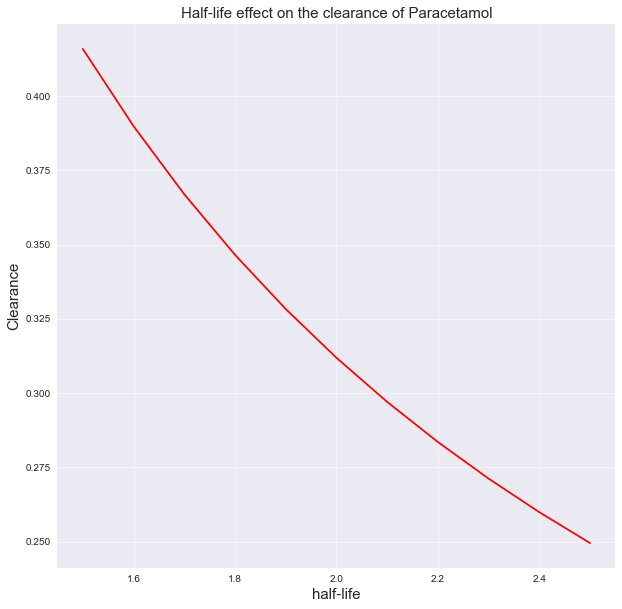

In [20]:
# Set range of half life
T_half_range = np.arange(1.5, 2.6, 0.1)

# Defining volume of distribution (Vd)
Vd = 0.9

# Modelling the clearance using the pharmacokinetic equations
Clearance = ((np.log(2)) / (T_half_range)) * (Vd)

# Plotting the graph
plt.figure(figsize = (10,10))
plt.plot(T_half_range, Clearance, color = 'red')

plt.title('Half-life effect on the clearance of Paracetamol', fontsize = 15)
plt.ylabel('Clearance', fontsize = 15)
plt.xlabel('half-life', fontsize = 15)

plt.grid(alpha = 0.5)
plt.show()

From the graph above, we can determine that as the half-life of paracetamol increases, there is an exponential decrease in the clearance.

# Chapter 5 - Applying ADME in real life
Let us now apply our knowledge of Absorption, Distribution, Metabolism and Elimination (ADME) to a real world setting! As mentioned in the introduction, it is crucial for the clinician to administer the correct dose that results in the drug concentration being within the therapeutic range, in order to achieve the greatest effect without toxicities.

Diazepam is a useful pre-medication for relief of anxiety and tension in patients who are to undergo surgical procedures. It can be adminstered intravenuously for relief of anxiety and tension and to diminish the patient's recall of the procedure.

Assume the minimum effective concentration to be **14mg/L** and the minimum toxic concentration to be **18mg/L**. The pharmacokinetic properties of diazepam is as follows:

In [21]:
# Slicing the pk_data dataframe for diazepam
diazepam = pk_data.loc[pk_data['Name'].isin(['Diazepam'])]

display(diazepam)

,Name,Vol. Distribution (L/kg),Clearance (mL/min/kg),Mean Residence Time (h),Half-life (h),Molecular Weight,HBA,HBD,Total Polar Surface Area,Ionic State,LogP
381,Diazepam,1.0,0.38,44.0,42.0,284.74,3,0,32.7,neutral,2.8


We have defined a function to model the blood concentration of diazepam over time. 

In [22]:
def diazepam_conc(dose = 16, min_therapeutic_conc = 14, min_toxic_conc = 18, clearance = 0.38):
    '''Returns a graph to model the plasma concentration of diazepam in the patient of model 60kg.
    The model will also return the time which diazepam loses its beneficial effect in the patient. Consider administering the next dose at this time.
    
    Arguments
    dose: dose of diazepam given (mg)
    min_therapeutic_conc: minimum therapeutic concentration where a physiological effect is observed (mg/L)
    min_toxic_conc: minimum concentration where a toxic effect is observed (mg/L)
    clearance: clearance rate (mL/min)'''
    
    
    if min_toxic_conc > min_therapeutic_conc:
        
        # Determining the variables used in the IV dose equation
        clearance = clearance/1000 * 60 # Clearance set to correct units for equation
        vd = diazepam['Vol. Distribution (L/kg)'].iloc[0] # Volume of distribution
        ke = clearance/vd # Elimination constant
        c_0 = dose / vd # Initial concentration
        
        # Set time range for 4 days (96 hours)
        t = np.arange(0,96,0.1)

        
        # Modelling the drug plasma concentrations using the pharmacokinetic equations
        
        # Iv_dose at each time point
        iv_dose = c_0 * np.exp(-ke *t) 
        
        # Solving for t_min, the time which the drug concentration decreases below its minimum therapeutic concentration
        t_min = np.log(min_therapeutic_conc / c_0) / - ke 

        # Plotting the graph to visualise IV dose concentration over time
        plt.figure(figsize = (10,10))
        plt.plot(t,iv_dose)
        
        # Plot the therapeutic range
        plt.plot(plt.xlim(),[min_therapeutic_conc ,min_therapeutic_conc ],'g--',plt.xlim(),
                 [min_toxic_conc,min_toxic_conc],'r--')
    

        plt.xlim(0,100)
        plt.ylim(0,20)
        plt.legend(['Diazepam Concentration','Maximum Effective Concentration','Minimum Effective Concentration'],
                   loc = 'lower right', frameon = True)
        
        plt.xlabel('Time [hours]', fontsize = 15)
        plt.ylabel('Concentration [mg/L]', fontsize = 15)
        
        plt.grid(alpha = 0.2)
        plt.title('Diazepam Blood Plasma Concentration', fontsize = 15)

        # Display the time when drug loses beneficial effect
        if c_0 >= min_therapeutic_conc:
                plt.vlines(t_min, 0, min_therapeutic_conc , ls = 'dashed', color = 'grey', alpha = 0.5)
                plt.text(x = t_min + 2 , y = 0.5, s = f'Drug loses effect \nat t = {t_min.round(2)}h',
                         color = 'hotpink', fontsize = 15)
                
                # Print a warning if the initial drug dose is too toxic
                if c_0 >= min_toxic_conc:
                    print('Drug shows toxic effect!') 
        else:
            # Print a statement to describe no observed effect of the drug
            print('Drug has no observed effect')
        
        plt.show()
        
    else:
        # Print warning if the parameters are set wrongly
        print('Minimum therapeutic concentration needs to be lower than Minimum toxic concentration!')

The following is a sample output of dose = 16mg, minimum therapeutic concentration = 14mg/L, minimum toxic concentration = 18mg/L and clearance = 0.38mL/min.

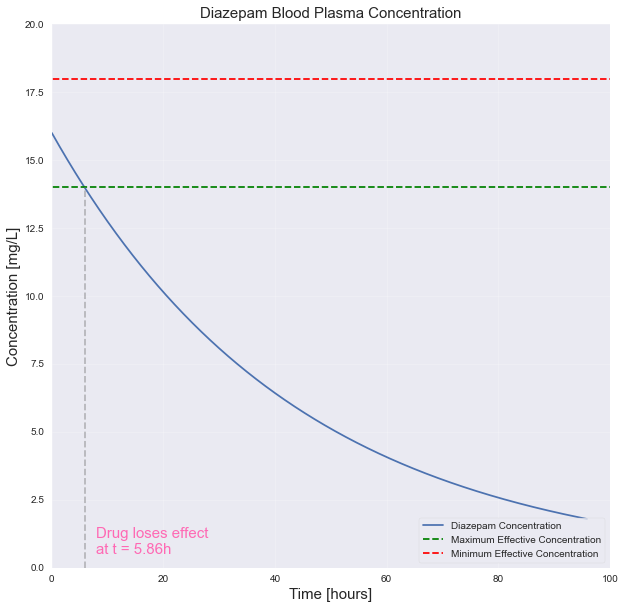

In [23]:
diazepam_conc()

### Your turn to try!

Imagine that you are a clinician that is about to administer diazepam to your patient intravenously. Your patient is suffering from liver cirrhosis (impaired hepatic function) and hence, the **maximum tolerable dose** (minimum toxic concentration) is **lowered**.

Use the function defined above to model the drug concentration over time to determine how changes in clearance affects the amount of time the drug remains at a sufficient concentration to exert its effect.

In [24]:
# YOUR CODE HERE
dose = 
min_therapeutic_conc = 
min_toxic_conc = 
clearance = 
diazepam_conc(dose, min_therapeutic_conc, min_toxic_conc, clearance)

SyntaxError: invalid syntax (Temp/ipykernel_10888/2471392105.py, line 2)

# 6. Bonus Section: The Two-Compartment Model 


### 6.1 Limitations of a one-compartment model
We have seen how the elimination rate constant can be calculated for drugs in Chapter 4.1. However, it turns out that not all drugs can be modelled in that way. When we use a one-compartment model, we assume that the **distribution and equilibrium of the drug throughout the body happens instantaneously**. However, very little drugs display immediate distribution through the body. Hence, in order to model the data better, we will have to alter our model, which is where the **two-compartment model** comes in.

<img src="distribution.png" width="400"/><center><em>The differences in distribution rates between a one-compartmental model and two-compartmental model. Image obtained from _Concepts in Clinical Pharmacokinetics (5th Edition)_</em></center>

### 6.2 The Two-Compartment Model
Multi-compartmental models are not used as frequently as the one-compartment model, partly due to the difficulty in constructing and applying the model. 

Generally, multicompartment models are applied when the natural logarithm of the plasma drug concentration versus time curve is not a straight line after an intravenous dose or when the plasma concentration versus time profile cannot be characterised by a single exponential function, $C = C_0 \cdot e^{-k \cdot t}$

<img src="comparison.jpg" width="500"/><center><em>Comparing a one-compartment model and a two-compartment model.</em></center>

A natural logarithm of plasma drug concentration versus time curve for a two-compartment model shows a curvilinear profile - a curved portion followed by a straight line. This is biexponential curve can be depicted by two-exponential terms. The phases of the curve may represent rapid distribution to organs with high blood flow (**central compartment**) and slower distribution to organs with less blood flow (**peripheral compartment**).

In this chapter, we briefly introduce the mathematic principles of the two-compartment model to calculate useful pharmacokinetic parameters. We will be using the pharmacokinetic data of Diazepam to guide you along. 

Dataset for Diazepam was adapted from: [Klotz et al., (1975)](https://pubmed.ncbi.nlm.nih.gov/1127104/)

In [25]:
diazepam = pd.read_csv('diazepam.csv')

diazepam = diazepam.filter(['concentration', 'time'])

# Getting logarithm of concentration values and creating a new column

diazepam['lnC'] = np.log(diazepam['concentration'])
display(diazepam)

,concentration,time,lnC
0,0.000274,1.012488,-8.203197
1,0.000230,1.166848,-8.377797
2,0.000139,1.465731,-8.884106
3,0.000115,1.784831,-9.067462
4,0.000088,2.759617,-9.338174
5,0.000065,3.567477,-9.634988
6,0.000057,4.550459,-9.774215
7,0.000051,6.526805,-9.889585
8,0.000041,8.497141,-10.099502
9,0.000038,11.797973,-10.177924


From Chapter 4, we learnt that the elimination rate constant ($k_e$) is estimated from the slope of the natural logarithm of plasma drug concentration versus time curve. However, in a two-compartmental model, in which that the plot is **curvilinear**, the slope varies, depending on which portion of the curve is examined.

The slope of the **initial portion** is determined primarily by the **distribution rate**, whereas the slope of the terminal portion is determined primarily by the **elimination rate**.The linear (or post-distribution) **terminal portion** of the curve maybe **back-extrapolated to time zero ($t_0$)**. The negative slope of this line is referred to as _beta_($\beta$), and like $k_e$ in the one-compartmental model, **$\beta$** is the **elimination rate constant** for the two-compartmental model.

<img src="two-compartment.jpg" width="400"/><center><em>The components of the two-compartment model</em></center>

In [26]:
# Defining a function to find the gradient
def slope(x1, y1 , x2, y2):
    top = y2 - y1
    bottom = x2 - x1
    return top / bottom

# Using index 12 and 14 (the ends are part of the elimination phase)
beta = -slope(diazepam['time'][12], diazepam['lnC'][12], diazepam['time'][14], diazepam['lnC'][14])
print(f'The value of \u03B2 is {beta}.')

The value of β is 0.003787574525485153.


As in the one-compartmental model, half-life can be calculated from $\beta$:
$$ t_{1/2} = \frac{ln2}{\beta} $$
Throughout the time that drug is present in the body, distribution takes place in the central and peripheral compartments. We can calculate a rate of distribution using the **method of residuals**, which separates the effects of distribution and elimination. To apply the method of residuals, we use the **back-extrapolated line** used to determine $\beta$ and $b$, the y-intercept of the extrapolated elimination curve.

In [27]:
# Using the equation b = Y - mX 
b = diazepam['lnC'][12] - (-beta * diazepam['time'][12])
print(f'The value of b is {b}.')

# Seting our range of time, for the plots later 
time = np.arange(0,100,0.001)

# Elimination curve extrapolated
elimination = (-beta * time) + b

The value of b is -10.29310786934522.


Once we find $b$, we will be able to use the original equation from the one-compartmental model $C = Be^{-\beta \cdot t}$, where $B$ is the reverse logarithm of $b$.

In [28]:
B = np.exp(b)
print(f'The value of B is {B}.')

# Creating a function for C = Be^(-beta * t)
def conc_elim(t):
    return B * np.exp(-beta * t)

The value of B is 3.3865699521045406e-05.


Next, we will find out the actual concentration in the first phase (the steeper slope). Then, the concentration will be subtracted by the corresponding concentration at the same time point on the back-extrapolated elimination curve. These extrapolated points represent the **effect of elimination alone**, as if distribution had been **instantaneous**. Through subtraction, we obtain a new set of plasma concentration points at each time point. If we plot this points, we generate a new line, the **residual line**. 

The negative slope of the residual line is referred to as _alpha_ ($\alpha$), and $\alpha$ is the distribution rate constant for the two-compartment system. The y-intercept of the residual line is $a$. 

For the distribution curve, we are also able to use the one-compartment model equation $C = Ae^{-\beta \cdot t}$, where $A$ is the reverse logarithm of $a$.

In [29]:
# Using index 0 and 2 (the start is the distribution phase)
elimpoints = []
for i in range(0,3,2):
    elimpoints.append(conc_elim(diazepam['time'][i]))
    
# Finding C - C'(extrapolated beta curve), followed by taking the logarithm of the values to obtain the final line
distripoints = [(diazepam['concentration'][0] - elimpoints[0]), (diazepam['concentration'][2] - elimpoints[1])]
lnalpha = np.log(distripoints)

# Finding slope of my distribution curve
alpha = -slope(diazepam['time'][0], lnalpha[0], diazepam['time'][2], lnalpha[1])
print(f'The value of \u03B1 is {alpha}.')

# y-intercept of distribution curve
a = lnalpha[0] - (-alpha * diazepam['time'][0])
print(f'The value of a is {a}.')

# Distribution phase line (note: this is not a best fit of the first phase!)
distribution = (-alpha * time) + a

# Obtaining the coefficient A
A = np.exp(a)
print(f'The value of A is {A}.')

# Creating a function for C = Ae^(-alpha * t)
def conc_distri(t):
    return A * np.exp(-alpha * t)

The value of α is 1.8264869615007535.
The value of a is -6.485404825527685.
The value of A is 0.0015255430628487254.


Now, with the elimination and distribution curves obtained, we finally obtain the two-compartmental model! Let us plot the figure to see how our two-compartment model compares with the original Diazepam data.

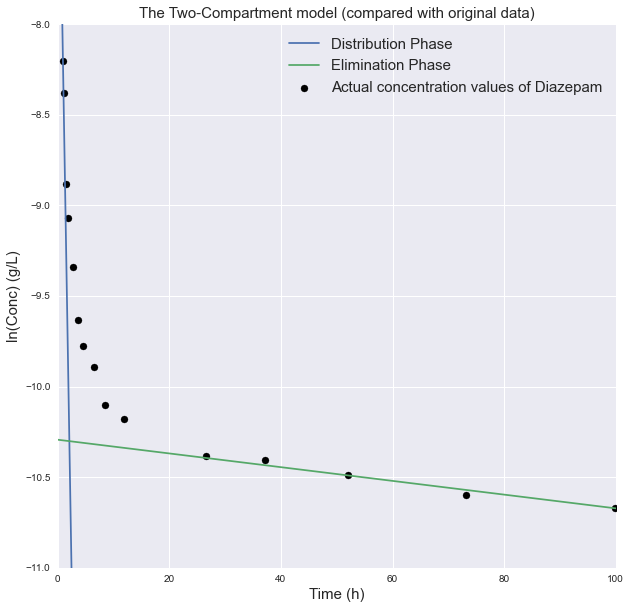

In [30]:
# Plotting the graph
plt.figure(figsize=(10, 10))

plt.plot(time,distribution, label = 'Distribution Phase')
plt.plot(time,elimination, label = 'Elimination Phase')
plt.scatter(diazepam['time'], diazepam['lnC'], label = 'Actual concentration values of Diazepam', color = 'black')

# Customising
plt.xlim(0,100)
plt.ylim(-11,-8)
plt.ylabel('ln(Conc) (g/L)',fontsize = 15)
plt.xlabel('Time (h)',fontsize = 15)
plt.title('The Two-Compartment model (compared with original data)', fontsize = 15)

plt.legend(fontsize = 15)

plt.show()

The two-compartment model is the **sum of two linear components**, representing distribution and elimination, so we can determine drug concentration ($C$) at any time ($t$) by adding those two components. With that, we finally obtain the two-compartmental model equation.

$$ C_{(t)} = A \cdot e^{- \alpha \cdot t} + B \cdot e^{- \beta \cdot t} $$

With this equation, we can try plotting the equation and compare with the original data points. 

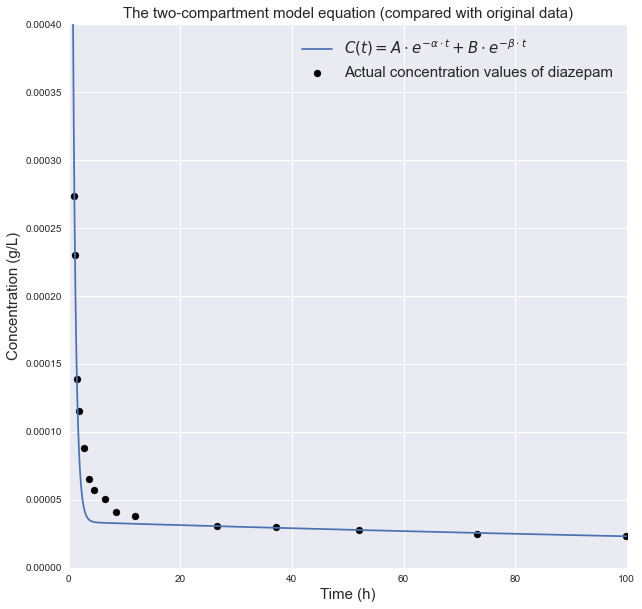

In [31]:
# Combining the two functions we defined earlier
two_compartment = conc_distri(time) + conc_elim(time)

# Plotting the curve
plt.figure(figsize=(10, 10))
plt.plot(time, two_compartment, label = r'$C(t) = A \cdot e^{- \alpha \cdot t} + B \cdot e^{- \beta \cdot t}$')
plt.scatter(diazepam['time'], diazepam['concentration'], label = 'Actual concentration values of diazepam', color = 'black')

# Customising
plt.xlim(0,100)
plt.ylim(0,0.0004)
plt.ylabel('Concentration (g/L)', fontsize = 15)
plt.xlabel('Time (h)', fontsize = 15)

plt.title('The two-compartment model equation (compared with original data)', fontsize = 15)
plt.legend(fontsize = 15)

plt.show()

From the graph above, we do see that the data points largely follow the equation, though there are some points that do not fit. Thus, though not perfect, it is able to more accurately reflect the behaviour of diazepam in the body.

# 7. Final Conclusion

Pharmacokinetics remains an important and integral part in pharmaceutical science and medicine. From the previous chapters, we have seen how many factors affect the absorption, distribution, metabolism and elimination of any drug that is taken into the body. The simple Python models have also allowed us to study these factors and has even allowed us to visualise the effects these factors have on the body.

However, these models are **constrained by many assumptions** that may not hold true in the real life setting. As exemplified from the previous chapter, we see that pharmacokinetics remains a very complex subject that requires many models.

Currently, many algorithms exist to model the pharmacokinetic behaviour of many drugs, especially with novel compounds. These algorithms make use of complex mathematics and machine learning to be able to accurately predict and model the profiles of drugs, based on their chemical structure etc. These have been instrumental in the field of drug discovery and clinical studies, ensuring that medicines continue to remain **safe and effective** in the future.

## Acknowledgements and References

Concept explanations in this notebook have been largely referenced from: DiPiro, J. T. & American Society of Health-System Pharmacists (Eds.). (2010). Concepts in Clinical Pharmacokinetics (5th ed). American Society of Health-System Pharmacists.

We would like to thank Dr. Chammika, Yuan Zhe and the rest of the SP2273 team for teaching the necessary Python concepts to make the creation of this notebook possible.

Also, we would like to thank A/Prof. Ho Han Kiat, Prof. Eric Chan and Dr. Wang Ziteng (Department of Pharmacy) for teaching us the basic concepts of pharmacokinetics and helping us obtain the neccessary data.